In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.19 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

#select this option to load version 2 (with 20 agents) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [7]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.14349999679252506


In [12]:
env.close()

In [3]:
#Model
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

#Xavier initialization 
# weight = U [-(1/sqrt(n)), 1/sqrt(n)]

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim,lim)

class Actor(nn.Module):
    def __init__(self,state_size,action_size,seed,fc1_units=128,fc2_units=128):
        super(Actor,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size,fc1_units)
        self.fc2 = nn.Linear(fc1_units,fc2_units)
        self.fc3 = nn.Linear(fc2_units,action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3,3e-3)
        
    def forward(self,state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))  # for -1 to +1 as tanh swings in that range
    
    
class Critic(nn.Module):
    def __init__(self,state_size,action_size,seed,fc1_units=128,fc2_units=128):
        super(Critic,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size,fc1_units)
        self.fc2 = nn.Linear(fc1_units+action_size,fc2_units)
        self.fc3 = nn.Linear(fc2_units,1)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3,3e-3)
        
    def forward(self,state,action):
        xs = F.relu(self.fc1(state))
        x = torch.cat((xs,action),dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)
        

In [4]:
import torch.optim as optim

BUFFER_SIZE = int(1e5)
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 1e-3
LR_ACTOR = 1e-3
LR_CRITIC = 1e-3
WEIGHT_DECAY = 0
EPSILON = 1.0
EPSILON_DECAY = 1e-6

LEARN_EVERY = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
from collections import namedtuple,deque
class ReplayBuffer:
    def __init__(self,action_size,buffer_size,batch_size,seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience",field_names=["state","action","reward","next_state","done"])
        self.seed = random.seed(seed)
        
    def add(self,state,action,reward,next_state,done):
        e = self.experience(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        return len(self.memory)

In [6]:
import copy
"""Ornstein-Uhlenbeck process."""
class OUNoise:
    def __init__(self,size,seed,mu=0.,theta=0.15,sigma=0.2):
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()
        
    def reset(self):
        self.state = copy.copy(self.mu)
        
    def sample(self):
        x = self.state
        #dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [7]:
class Agent():
    def __init__(self,state_size,action_size,random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        
        self.actor_local = Actor(state_size,action_size,random_seed).to(device)
        self.actor_target = Actor(state_size,action_size,random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(),lr=LR_ACTOR)
        
        self.critic_local = Critic(state_size,action_size,random_seed).to(device)
        self.critic_target = Critic(state_size,action_size,random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(),lr=LR_CRITIC,weight_decay=WEIGHT_DECAY)
        
        self.noise = OUNoise(action_size,random_seed)
        self.memory = ReplayBuffer(action_size,BUFFER_SIZE,BATCH_SIZE,random_seed)
        self.epsilon = EPSILON
        self.step_t = 0
        
    def step(self,state,action,reward,next_state,done):
        self.memory.add(state,action,reward,next_state,done)
        self.step_t += 1
        self.step_t %= LEARN_EVERY
        
        if len(self.memory) > BATCH_SIZE:
            if self.step_t == 0:
                experiences = self.memory.sample()
                self.learn(experiences,GAMMA)
            
    def act(self,state,add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.epsilon = self.epsilon - EPSILON_DECAY
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
            
        self.actor_local.train()
        
        if add_noise:
            action += np.maximum(self.epsilon, 0.1)*self.noise.sample() #edited
            
        return np.clip(action,-1,1)
    
    
    def reset(self):
        self.noise.reset()
        
    def learn(self,experiences,gamma):
        states,actions,rewards,next_states,dones = experiences
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states,actions_next)
        
        Q_targets = rewards + (gamma * Q_targets_next)  # no dones
        Q_expected = self.critic_local(states,actions)
        critic_loss = F.mse_loss(Q_expected,Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        #actor
        actor_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states,actor_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        self.soft_update(self.critic_local,self.critic_target,TAU)
        self.soft_update(self.actor_local,self.actor_target,TAU)
        
        
    def soft_update(self,local_model,target_model,tau):
        
        for target_param,local_param in zip(target_model.parameters(),local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
        

In [8]:
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [9]:
import random
agent = Agent(state_size,action_size,random_seed=0)

In [10]:
import matplotlib.pyplot as plt
from workspace_utils import keep_awake
import time

def ddpg(n_episodes=3000,max_t=1000,print_every=100):
    scores = []
    moving_avg = []
    
    for i_episode in keep_awake(range(n_episodes+1)):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        #print(states.shape) #(20, 33)
        agent.reset()
        scores_episode = np.zeros(num_agents)
        
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            for (state,action,reward,next_state,done) in zip (states,actions,rewards,next_states,dones):
                agent.step(state,action,reward,next_state,done)
            
            states = next_states
            scores_episode += rewards
            
        scores.append(scores_episode.tolist())
        moving_avg.append(np.mean(scores[-print_every:],axis=0))
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg[-1].mean(), end="\r"))
        #time.sleep(0) # for carriage return overwrite problem
        torch.save(agent.actor_local.state_dict(), 'multi_agent_checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'multi_agent_checkpoint_critic.pth')
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg[-1].mean()))
            
            if moving_avg[-1].mean() > 30:
                print('\rEnvironment solved in {} episodes with an Average Score of {:.2f}'.format(i_episode, moving_avg[-1].mean()))
                torch.save(agent.actor_local.state_dict(), 'multi_agent_checkpoint_actor_final.pth')
                torch.save(agent.critic_local.state_dict(), 'multi_agent_checkpoint_critic_final.pth')
                return scores,moving_avg
            #print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))
            
    return scores,moving_avg

In [11]:
scores, moving_avg = ddpg()

Episode 0	Average Score: 0.04
Episode 0	Average Score: 0.04
Episode 1	Average Score: 0.35
Episode 2	Average Score: 0.58
Episode 3	Average Score: 0.71
Episode 4	Average Score: 0.81
Episode 5	Average Score: 0.85
Episode 6	Average Score: 0.83
Episode 7	Average Score: 0.77
Episode 8	Average Score: 0.69
Episode 9	Average Score: 0.73
Episode 10	Average Score: 0.73
Episode 11	Average Score: 0.72
Episode 12	Average Score: 0.77
Episode 13	Average Score: 0.83
Episode 14	Average Score: 0.87
Episode 15	Average Score: 0.93
Episode 16	Average Score: 0.97
Episode 17	Average Score: 1.04
Episode 18	Average Score: 1.08
Episode 19	Average Score: 1.15
Episode 20	Average Score: 1.25
Episode 21	Average Score: 1.36
Episode 22	Average Score: 1.44
Episode 23	Average Score: 1.50
Episode 24	Average Score: 1.57
Episode 25	Average Score: 1.65
Episode 26	Average Score: 1.72
Episode 27	Average Score: 1.81
Episode 28	Average Score: 1.91
Episode 29	Average Score: 1.98
Episode 30	Average Score: 2.04
Episode 31	Average 

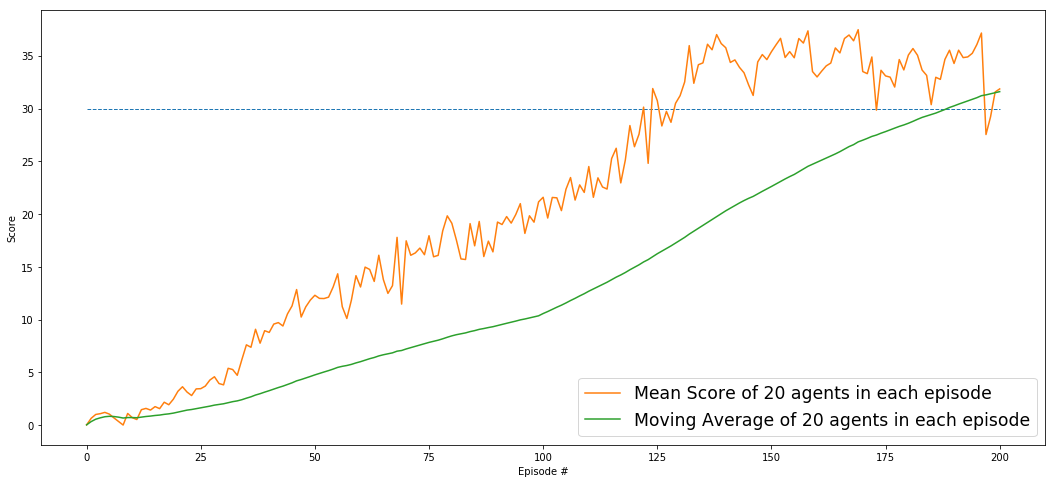

In [21]:
scores_mean = np.mean(scores,axis=1)
moving_avg_mean = np.mean(moving_avg,axis=1)

target = [30] * len(scores) 
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(target, linestyle='--',linewidth=1, zorder=0)
ax.plot(scores_mean,label='Mean Score of 20 agents in each episode')
ax.plot(moving_avg_mean,label='Moving Average of 20 agents in each episode')
plt.ylabel('Score')
plt.xlabel('Episode #')
ax.legend(fontsize='xx-large', loc='lower right')

plt.show()

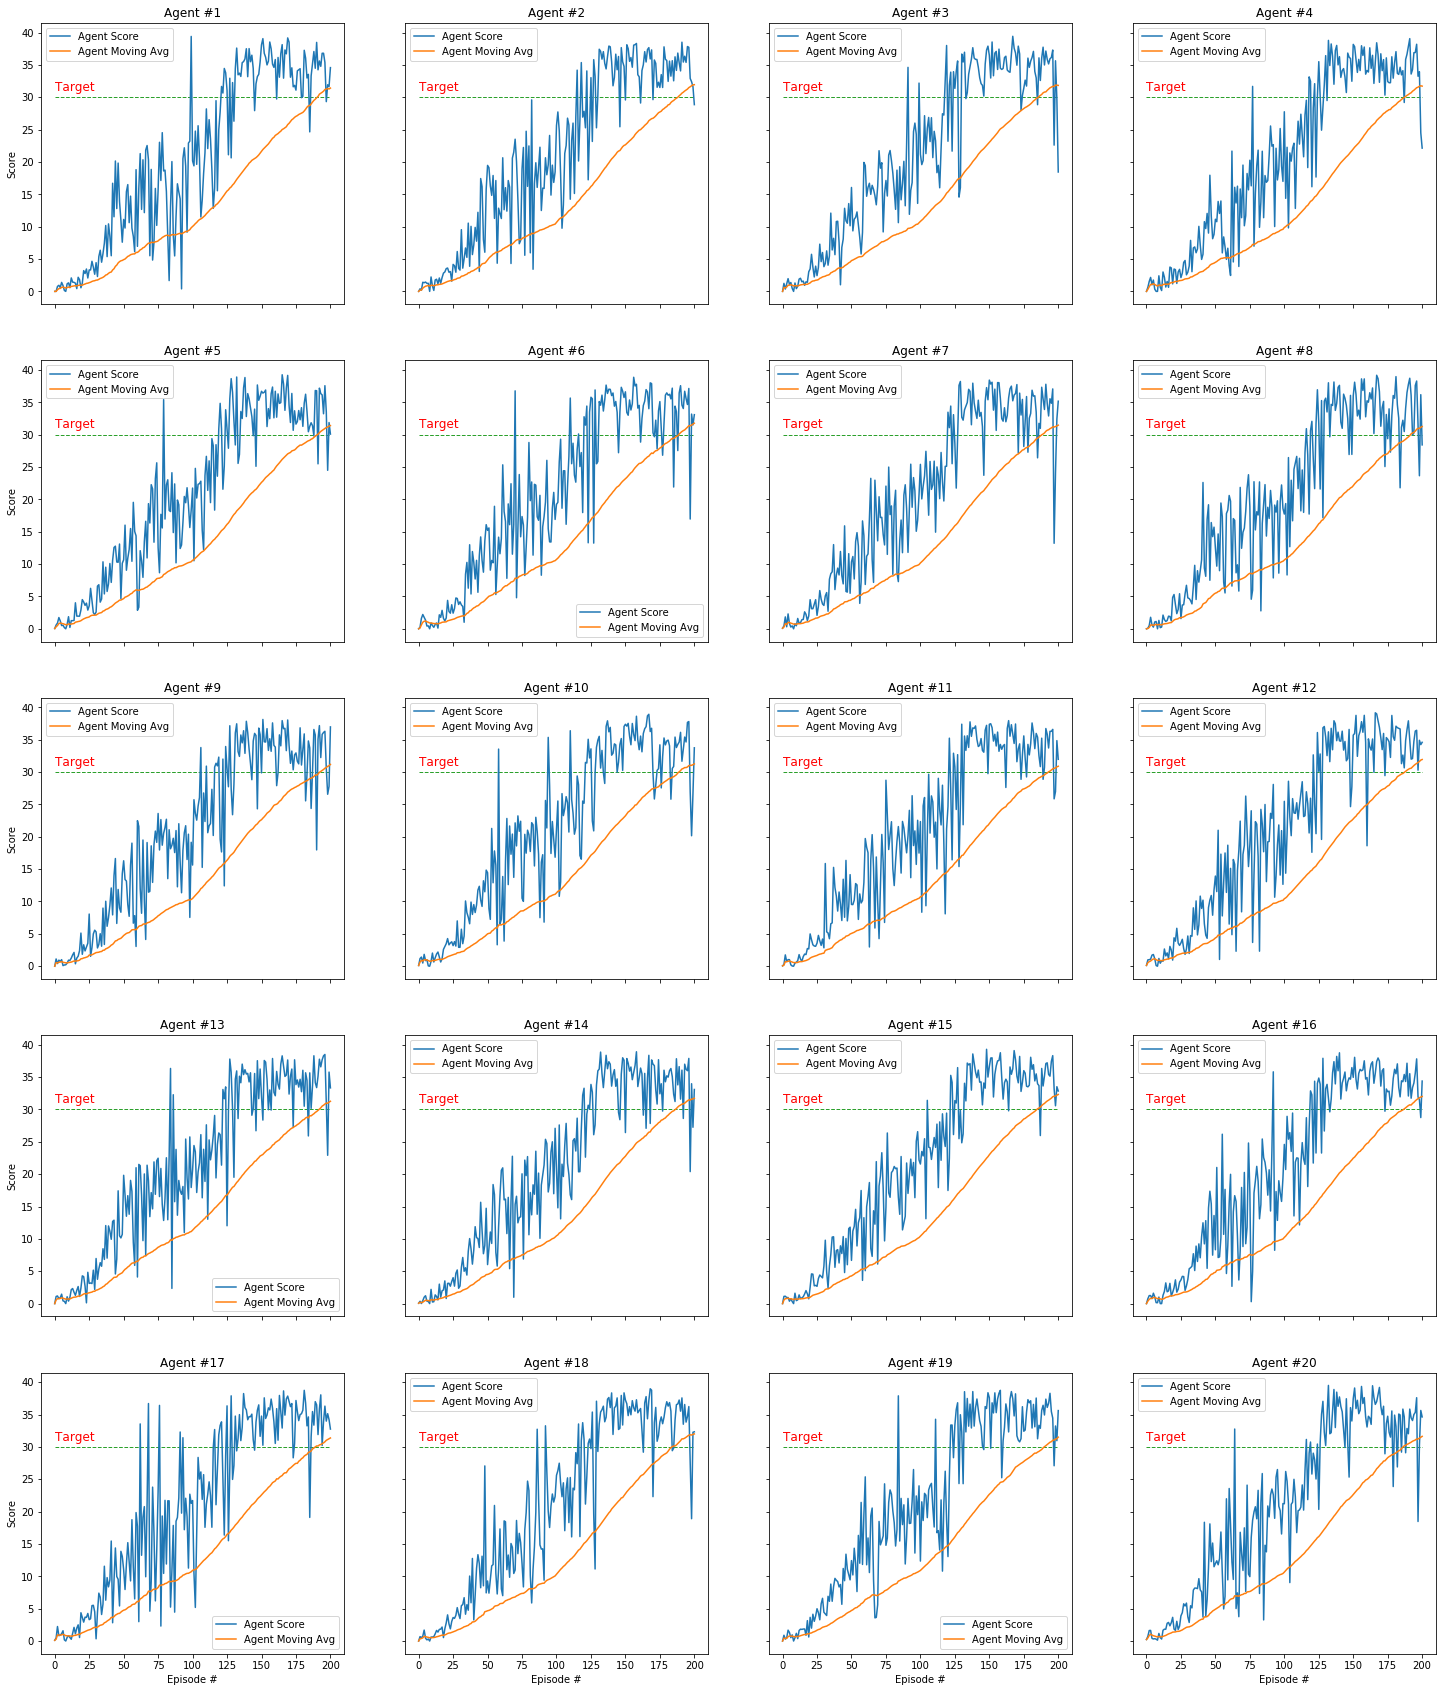

In [20]:
fig, axs = plt.subplots(5, 4, figsize=(25, 30), sharex=True, sharey=True)
axs = axs.flatten()

target = [30] * len(scores) 

for idx, (ax,s,m) in enumerate(zip(axs,np.transpose(scores),np.transpose(moving_avg))):
    ax.plot(s,label='Agent Score',zorder=1)
    ax.plot(m,label='Agent Moving Avg',zorder=2)
    ax.plot(target, linestyle='--',linewidth=1, zorder=0)
    ax.text(0, 30+1, 'Target', color='Red', fontsize='large')
    ax.set_title('Agent #%d' % (idx+1))
    ax.set_ylabel('Score')
    ax.set_xlabel('Episode #')
    ax.label_outer()
    ax.legend(fontsize='medium')
    
plt.show()